# Curate acoustic data

Notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- **2-curate_acoustics**
- 3-sort_spikes
- 4-curate_spikes

Use the environment **songproc** to run this notebook

In [1]:
%matplotlib widget
import os
import numpy as np
import pandas as pd
import pickle
import IPython.display as ipd
import sys
sys.path.append('/mnt/cube/lo/envs/ceciestunepipe')
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.pipeline import searchbout as sb
from ceciestunepipe.mods import curate_bouts as cb

import logging
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.WARNING) # set to logging.INFO if you'd like to see the full readout

## Set parameters

In [2]:
# session parameters
sess_par = {
    'bird':'z_r5r13_24', # bird ID
    'sess':'2024-08-08', # session date
    'ephys_software':'sglx', # recording software, sglx or oe
    'stim_sess':True, # if song stimulus was played during the session
    'stim_epoch':['2355_g0'], # mark all detections as song for these overnight epochs
    'trim_bouts':True, # manually trim bouts after curation
    'sort':'sort_0', # sort index
}

# set type of ALSA bout dataframe to load, depending on how far it's been previously processed
bout_df_type = 'auto' # options are 'auto' (not checked), 'checked' (checked not trimmed), and 'curated' (checked and trimmed)

## Load bouts captured through ADC channels in neural acquisition

In [3]:
# load bouts
hparams, bout_df = sb.load_bouts(sess_par['bird'],sess_par['sess'],'',
                                derived_folder='bouts_{}'.format(sess_par['ephys_software']),
                                bout_file_key='bout_sync_file')

# get sample rate and ensure same for all bouts
fs, bout_dicts_all = cb.epoch_bout_dict_sample_rate_check(bout_df, sess_par)

# if stim session, remove stim that overlap with bouts
bout_df_updated = bout_df.copy()
bout_df_updated = bout_df_updated.assign(bout_check=False, confusing=False, is_call=False)
# bout_df_updated = bout_df_updated.sort_values(by=['epoch', 'start_sample'])
if sess_par['stim_sess']:
    bout_df_updated.loc[bout_df_updated['epoch'].isin(sess_par['stim_epoch']), 'bout_check'] = True
    len_bouts = len(bout_df_updated[bout_df_updated['bout_check']==False])
    print('All bouts:',len(bout_df), '| Post stim removal:',len_bouts)
    first_bout = bout_df_updated[~bout_df_updated['epoch'].isin(sess_par['stim_epoch'])].index[0]
    last_bout = bout_df_updated[~bout_df_updated['epoch'].isin(sess_par['stim_epoch'])].index[-1]
    print('Bouts post stim removal begin at index',first_bout,'and end at index',last_bout)
else:
    len_bouts = len(bout_df)
    print('Bouts:',len(bout_df))

All bouts: 1273 | Post stim removal: 603
Bouts post stim removal begin at index 0 and end at index 602


## Load bouts captured through alsa

In [4]:
# load bouts
bout_df_alsa = sb.load_bouts_alsa(sess_par['bird'], sess_par['sess'], bout_df_type)

# get sample rate and ensure same for all bouts
fs_alsa = cb.bout_fs_check(bout_df_alsa)

### not doing anything with this yet, but could load bouts for the whole day and pair with SGLX session ###

## Curate bouts
Review results of automatic bout detection algorithm to remove any false bout detections

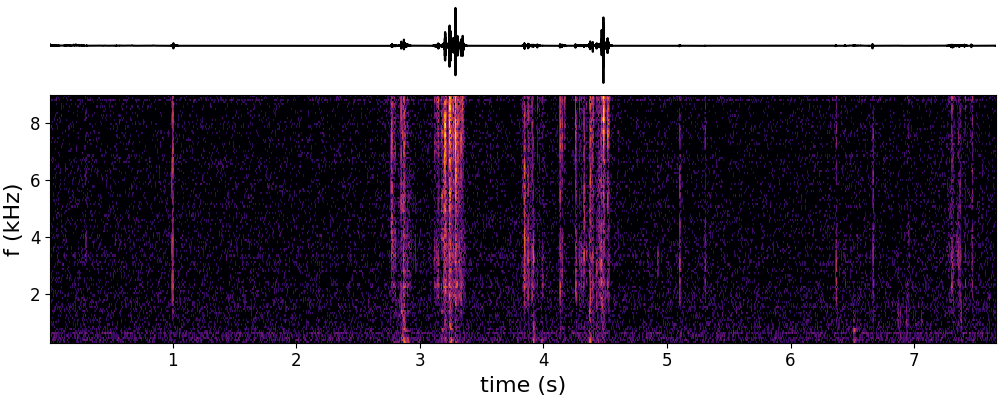

In [4]:
viz_bout = cb.VizBout(bout_df_updated, fs)

#### Option to listen to a bout

In [7]:
bout_idx = 405
ipd.Audio(bout_df_updated.iloc[bout_idx]['waveform'],rate=fs)

In [5]:
# generate bout summaries
print(f"Out of {len(bout_df_updated.head(len_bouts))} potential bouts:")
print(f"• {bout_df_updated['bout_check'].head(len_bouts).sum() - bout_df_updated['is_call'].head(len_bouts).sum()} songs")
print(f"• {bout_df_updated['is_call'].head(len_bouts).sum()} calls")
print(f"• {len(bout_df_updated.head(len_bouts)) - bout_df_updated['bout_check'].head(len_bouts).sum()} noise")

Out of 603 potential bouts:
• 45 songs
• 0 calls
• 558 noise


## Trim bouts:
Now that you have only the true bouts, trim the start and end points to align precise with bout onset and offset. This will improve the performance of syllable segmentation and clustering in later steps.

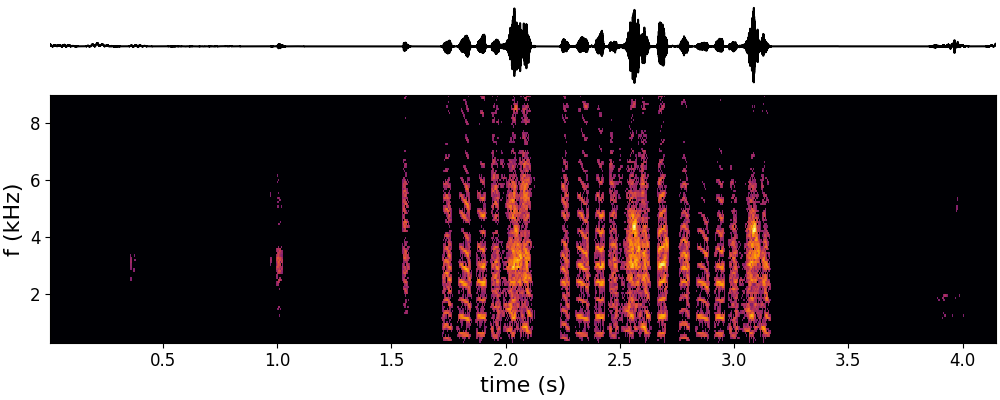

In [6]:
if sess_par['trim_bouts']:
    filtered_bout_df = viz_bout.bouts_pd[(viz_bout.bouts_pd['bout_check'] == True) & 
                                         (viz_bout.bouts_pd['is_call'] == False)]
    if len(filtered_bout_df)>0:
        trim_bouts = cb.TrimBout(filtered_bout_df, fs)
    else:
        print('No bouts to trim...')
else:
    print('Skipping bout trimming..')

In [10]:
bout_idx = 0
ipd.Audio(filtered_bout_df.iloc[bout_idx]['waveform'],rate=fs)

In [7]:
# generate final bout df
if sess_par['trim_bouts']:
    if len(filtered_bout_df)>0:
        # pull out trim values
        start_s = trim_bouts.crop_min; end_s = trim_bouts.crop_max
        bout_df_final = cb.update_trimmed_bouts(filtered_bout_df, start_s, end_s, fs, fs_ap=30000)
    else:
        bout_df_final = filtered_bout_df
else:
    bout_df_final = viz_bout.bouts_pd.copy()

## Save curated acoustics

In [8]:
# save overall curated bout df
sb.save_auto_bouts(bout_df_final,sess_par,hparams,software=sess_par['ephys_software'],bout_file_key='bout_curated_file')

# loop through epochs - save curated data frames and dictionaries for each
for i,this_epoch in enumerate(np.unique(bout_df_final.epoch)):
    this_epoch_bout_df_final = bout_df_final.copy()
    epoch_struct = et.sgl_struct(sess_par,this_epoch,ephys_software=sess_par['ephys_software'])
    
    # get epoch bouts
    drop_condition = ~this_epoch_bout_df_final['file'].str.contains(this_epoch)
    this_epoch_bout_df_final.drop(this_epoch_bout_df_final[drop_condition].index, inplace=True)
    this_epoch_bout_df_final.reset_index(drop=True, inplace=True)
    
    # get bout dictionary
    this_bout_dict = bout_dicts_all[i]
    
    # update bout dictionary if necessary
    if sess_par['trim_bouts']:
        trim_keys = list(this_epoch_bout_df_final.keys()[this_epoch_bout_df_final.keys().str.contains('trim')])
        for this_key in trim_keys:
            this_bout_dict[this_key] = this_epoch_bout_df_final[this_key]
    
    # save curated bout dataframe and dictionary
    bout_dict_path = os.path.join(epoch_struct['folders']['derived'],'bout_dict_ap0_curated.pkl')
    with open(bout_dict_path, 'wb') as handle:
        pickle.dump(this_bout_dict, handle)
    bout_df_path = os.path.join(epoch_struct['folders']['derived'],'bout_pd_ap0_curated.pkl')
    this_epoch_bout_df_final.to_pickle(bout_df_path)

### Display bout times

In [9]:
for i, r in bout_df_final.iterrows():
    if i > last_bout: break
    
    hr_start = int(r['file'][-19:-17])
    hr_end = hr_start
    mn = int(r['file'][-17:-15])
    
    mn_start = int(mn + r['start_ms']/60000)
    sec_start = int((mn + r['start_ms']/60000 - mn_start) * 60)
    while mn_start > 59:
        mn_start = mn_start-60
        hr_start = hr_start+1
    
    mn_end = int(mn + r['end_ms']/60000)
    sec_end = int((mn + r['end_ms']/60000 - mn_end) * 60)
    while mn_end > 59:
        mn_end = mn_end-60
        hr_end = hr_end+1
    
    if i < 10:
        print("index {}:   ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))
    elif i < 100:
        print("index {}:  ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))
    else:
        print("index {}: ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))

index 270:  8:04:51 - 8:04:54  (2.9s long)
index 271:  8:05:00 - 8:05:04  (4.7s long)
index 376:  8:37:23 - 8:37:29  (6.3s long)
index 377:  8:37:38 - 8:37:41  (2.6s long)
index 413:  8:53:05 - 8:53:12  (6.9s long)
index 415:  8:53:21 - 8:53:24  (3.4s long)
index 416:  8:53:31 - 8:53:32  (1.5s long)
index 450:  9:03:23 - 9:03:32  (9.3s long)
index 453:  9:04:31 - 9:04:37  (6.2s long)
index 457:  9:10:35 - 9:10:42  (7.0s long)
index 470:  9:14:35 - 9:14:40  (5.5s long)
index 475:  9:16:27 - 9:16:34  (7.0s long)
index 494:  9:23:01 - 9:23:05  (4.2s long)
index 508:  9:28:25 - 9:28:30  (4.6s long)
index 509:  9:28:33 - 9:28:36  (3.4s long)
index 510:  9:28:55 - 9:28:59  (4.0s long)
index 511:  9:29:38 - 9:29:41  (3.6s long)
index 517:  9:32:08 - 9:32:14  (6.5s long)
index 518:  9:32:20 - 9:32:26  (5.7s long)
index 519:  9:32:35 - 9:32:38  (3.2s long)
index 521:  9:32:49 - 9:32:52  (3.1s long)
index 522:  9:33:09 - 9:33:17  (7.9s long)
index 523:  9:33:27 - 9:33:31  (3.9s long)
index 524: 

## Concatenating sessions

In [67]:
bout_df_final.head(18)

,file,start_sample,end_sample,start_ms,end_ms,len_ms,waveform,fem_waveform,spectrogram,sample_rate,...,valid,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,bout_check,confusing,is_call
45,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,88356760,88673640,2208919,2216841,7922,"[471, 486, 469, 502, 489, 472, 453, 528, 544, ...","[-255, -238, -251, -283, -266, -251, -247, -24...","[[0.1069199546870063, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,2208960,66268458,88293400,z_r5r13_24,2024-08-07,0949_g0,True,False,False
142,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,306126440,306319280,7653161,7657982,4821,"[690, 720, 722, 670, 711, 687, 702, 641, 663, ...","[-202, -205, -234, -205, -210, -204, -202, -22...","[[0.04617063032697592, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,7653305,229597967,306070440,z_r5r13_24,2024-08-07,0949_g0,True,False,False
153,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,319266360,319406360,7981659,7985159,3500,"[619, 598, 635, 569, 599, 605, 559, 618, 579, ...","[-326, -328, -328, -329, -331, -327, -330, -32...","[[0.021999940761009317, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,7981810,239453041,319266360,z_r5r13_24,2024-08-07,0949_g0,True,False,False
155,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,323347800,323568320,8083695,8089208,5513,"[424, 430, 441, 415, 436, 395, 462, 408, 470, ...","[-212, -208, -209, -216, -216, -183, -213, -20...","[[0.034754266281730006, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8083847,242514164,323328320,z_r5r13_24,2024-08-07,0949_g0,True,False,False
156,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,324018040,324186040,8100451,8104651,4200,"[367, 315, 366, 313, 327, 350, 351, 298, 368, ...","[-272, -295, -278, -276, -274, -271, -278, -27...","[[0.04861262692254681, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,8100604,243016851,323998040,z_r5r13_24,2024-08-07,0949_g0,True,False,False
157,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,324624120,324808040,8115603,8120201,4598,"[730, 701, 703, 694, 681, 706, 734, 694, 691, ...","[-194, -191, -185, -190, -181, -189, -177, -18...","[[0.020798472369377728, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8115756,243471416,324576680,z_r5r13_24,2024-08-07,0949_g0,True,False,False
158,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,325398080,325617240,8134952,8140431,5479,"[606, 575, 590, 593, 554, 601, 563, 605, 568, ...","[-271, -288, -273, -275, -283, -281, -267, -28...","[[0.053783507904516886, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8135105,244051894,325377240,z_r5r13_24,2024-08-07,0949_g0,True,False,False
159,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,331901560,332095280,8297539,8302382,4843,"[746, 732, 730, 750, 728, 778, 685, 742, 734, ...","[-290, -257, -271, -257, -266, -270, -253, -25...","[[0.10646443110827125, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,8297695,248929571,331855280,z_r5r13_24,2024-08-07,0949_g0,True,False,False
160,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,332316080,332481600,8307902,8312040,4138,"[547, 567, 574, 512, 527, 506, 507, 524, 513, ...","[-242, -234, -237, -236, -238, -238, -233, -22...","[[0.0417131455845805, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,8308059,249240465,332281600,z_r5r13_24,2024-08-07,0949_g0,True,False,False
161,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,333613360,333827600,8340334,8345690,5356,"[928, 981, 879, 913, 945, 921, 937, 964, 924, ...","[-194, -196, -190, -194, -204, -183, -201, -21...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,8340491,250213439,333587600,z_r5r13_24,2024-08-07,0949_g0,True,False,False


In [34]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='sglx')
source_folder = exp_struct['folders']['derived']
wav_path_list = et.get_sgl_files_epochs(source_folder, file_filter='*wav_mic.{}'.format('npy'))

In [35]:
wav_path_list

['/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/0949_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/1226_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/1227_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/1233_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/1235_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/1245_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/2355_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/2631_g0/wav_mic.npy']

In [59]:
file_path = wav_path_list[4]
file_path

'/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/1235_g0/wav_mic.npy'

In [60]:
npy_path = file_path.split('.')[0] + '.npy'
pkl_path = npy_path.split('.')[0] + '-npy_meta.pickle'
with open(pkl_path, 'rb') as fp:
    meta_dict = pickle.load(fp)
x = np.load(npy_path, mmap_mode='r').astype(meta_dict['dtype']).reshape(meta_dict['shape'])
s_f = meta_dict['s_f']

In [38]:
sample_offset = len(x)
sample_offset

376411488

In [39]:
ms_offset = round(len(x)/s_f*1000)
ms_offset

9410287

In [61]:
## just kept looping through this when I had to stitch 6 recordings together
# sample_offset = sample_offset + len(x)
# ms_offset = ms_offset + round(len(x)/s_f*1000)

410945921

In [40]:
bout_df_new = bout_df_final.copy()

In [63]:
offset_idx = bout_df_new[bout_df_new['epoch']=='1245_g0'].index.tolist()
offset_idx

[196]

In [64]:
for i in offset_idx:
    bout_df_new.at[i, 'start_sample'] = bout_df_final.at[i, 'start_sample'] + sample_offset
    bout_df_new.at[i, 'end_sample'] = bout_df_final.at[i, 'end_sample'] + sample_offset
    bout_df_new.at[i, 'start_ms'] = bout_df_final.at[i, 'start_ms'] + ms_offset
    bout_df_new.at[i, 'end_ms'] = bout_df_final.at[i, 'end_ms'] + ms_offset

In [66]:
bout_df_new

,file,start_sample,end_sample,start_ms,end_ms,len_ms,waveform,fem_waveform,spectrogram,sample_rate,...,valid,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,bout_check,confusing,is_call
45,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,88356760,88673640,2208919,2216841,7922,"[471, 486, 469, 502, 489, 472, 453, 528, 544, ...","[-255, -238, -251, -283, -266, -251, -247, -24...","[[0.1069199546870063, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,2208960,66268458,88293400,z_r5r13_24,2024-08-07,0949_g0,True,False,False
142,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,306126440,306319280,7653161,7657982,4821,"[690, 720, 722, 670, 711, 687, 702, 641, 663, ...","[-202, -205, -234, -205, -210, -204, -202, -22...","[[0.04617063032697592, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,7653305,229597967,306070440,z_r5r13_24,2024-08-07,0949_g0,True,False,False
153,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,319266360,319406360,7981659,7985159,3500,"[619, 598, 635, 569, 599, 605, 559, 618, 579, ...","[-326, -328, -328, -329, -331, -327, -330, -32...","[[0.021999940761009317, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,7981810,239453041,319266360,z_r5r13_24,2024-08-07,0949_g0,True,False,False
155,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,323347800,323568320,8083695,8089208,5513,"[424, 430, 441, 415, 436, 395, 462, 408, 470, ...","[-212, -208, -209, -216, -216, -183, -213, -20...","[[0.034754266281730006, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8083847,242514164,323328320,z_r5r13_24,2024-08-07,0949_g0,True,False,False
156,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,324018040,324186040,8100451,8104651,4200,"[367, 315, 366, 313, 327, 350, 351, 298, 368, ...","[-272, -295, -278, -276, -274, -271, -278, -27...","[[0.04861262692254681, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,8100604,243016851,323998040,z_r5r13_24,2024-08-07,0949_g0,True,False,False
157,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,324624120,324808040,8115603,8120201,4598,"[730, 701, 703, 694, 681, 706, 734, 694, 691, ...","[-194, -191, -185, -190, -181, -189, -177, -18...","[[0.020798472369377728, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8115756,243471416,324576680,z_r5r13_24,2024-08-07,0949_g0,True,False,False
158,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,325398080,325617240,8134952,8140431,5479,"[606, 575, 590, 593, 554, 601, 563, 605, 568, ...","[-271, -288, -273, -275, -283, -281, -267, -28...","[[0.053783507904516886, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8135105,244051894,325377240,z_r5r13_24,2024-08-07,0949_g0,True,False,False
159,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,331901560,332095280,8297539,8302382,4843,"[746, 732, 730, 750, 728, 778, 685, 742, 734, ...","[-290, -257, -271, -257, -266, -270, -253, -25...","[[0.10646443110827125, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,8297695,248929571,331855280,z_r5r13_24,2024-08-07,0949_g0,True,False,False
160,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,332316080,332481600,8307902,8312040,4138,"[547, 567, 574, 512, 527, 506, 507, 524, 513, ...","[-242, -234, -237, -236, -238, -238, -233, -22...","[[0.0417131455845805, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,8308059,249240465,332281600,z_r5r13_24,2024-08-07,0949_g0,True,False,False
161,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,333613360,333827600,8340334,8345690,5356,"[928, 981, 879, 913, 945, 921, 937, 964, 924, ...","[-194, -196, -190, -194, -204, -183, -201, -21...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,8340491,250213439,333587600,z_r5r13_24,2024-08-07,0949_g0,True,False,False


In [98]:
ap_offset = 282322836

In [99]:
ap_sr = 29999.842180774747

In [100]:
ap_offset/ap_sr*1000

9410810.70689516

In [101]:
ap_ms_offset = round(ap_offset/ap_sr*1000)
ap_ms_offset

9410811

In [115]:
## just kept looping through this when I had to stitch 6 recordings together
# ap_offset = ap_offset + 14681207
# ap_ms_offset = ap_ms_offset + round(14681207/29999.844262295082*1000)

In [102]:
bout_df_concat = bout_df_new.copy()

In [117]:
# offset_idx = bout_df_new[bout_df_new['epoch']=='1245_g0'].index.tolist()
# offset_idx

[196]

In [118]:
for i in offset_idx:
    bout_df_concat.at[i, 'start_sample_ap_0'] = bout_df_new.at[i, 'start_sample_ap_0'] + ap_offset
    bout_df_concat.at[i, 'start_ms_ap_0'] = bout_df_new.at[i, 'start_ms_ap_0'] + ap_ms_offset

In [120]:
bout_df_concat

,file,start_sample,end_sample,start_ms,end_ms,len_ms,waveform,fem_waveform,spectrogram,sample_rate,...,valid,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,bout_check,confusing,is_call
45,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,88356760,88673640,2208919,2216841,7922,"[471, 486, 469, 502, 489, 472, 453, 528, 544, ...","[-255, -238, -251, -283, -266, -251, -247, -24...","[[0.1069199546870063, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,2208960,66268458,88293400,z_r5r13_24,2024-08-07,0949_g0,True,False,False
142,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,306126440,306319280,7653161,7657982,4821,"[690, 720, 722, 670, 711, 687, 702, 641, 663, ...","[-202, -205, -234, -205, -210, -204, -202, -22...","[[0.04617063032697592, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,7653305,229597967,306070440,z_r5r13_24,2024-08-07,0949_g0,True,False,False
153,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,319266360,319406360,7981659,7985159,3500,"[619, 598, 635, 569, 599, 605, 559, 618, 579, ...","[-326, -328, -328, -329, -331, -327, -330, -32...","[[0.021999940761009317, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,7981810,239453041,319266360,z_r5r13_24,2024-08-07,0949_g0,True,False,False
155,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,323347800,323568320,8083695,8089208,5513,"[424, 430, 441, 415, 436, 395, 462, 408, 470, ...","[-212, -208, -209, -216, -216, -183, -213, -20...","[[0.034754266281730006, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8083847,242514164,323328320,z_r5r13_24,2024-08-07,0949_g0,True,False,False
156,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,324018040,324186040,8100451,8104651,4200,"[367, 315, 366, 313, 327, 350, 351, 298, 368, ...","[-272, -295, -278, -276, -274, -271, -278, -27...","[[0.04861262692254681, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,8100604,243016851,323998040,z_r5r13_24,2024-08-07,0949_g0,True,False,False
157,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,324624120,324808040,8115603,8120201,4598,"[730, 701, 703, 694, 681, 706, 734, 694, 691, ...","[-194, -191, -185, -190, -181, -189, -177, -18...","[[0.020798472369377728, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8115756,243471416,324576680,z_r5r13_24,2024-08-07,0949_g0,True,False,False
158,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,325398080,325617240,8134952,8140431,5479,"[606, 575, 590, 593, 554, 601, 563, 605, 568, ...","[-271, -288, -273, -275, -283, -281, -267, -28...","[[0.053783507904516886, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,8135105,244051894,325377240,z_r5r13_24,2024-08-07,0949_g0,True,False,False
159,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,331901560,332095280,8297539,8302382,4843,"[746, 732, 730, 750, 728, 778, 685, 742, 734, ...","[-290, -257, -271, -257, -266, -270, -253, -25...","[[0.10646443110827125, 0.0, 0.0, 0.0, 0.0, 0.0...",40000,...,True,8297695,248929571,331855280,z_r5r13_24,2024-08-07,0949_g0,True,False,False
160,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,332316080,332481600,8307902,8312040,4138,"[547, 567, 574, 512, 527, 506, 507, 524, 513, ...","[-242, -234, -237, -236, -238, -238, -233, -22...","[[0.0417131455845805, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,8308059,249240465,332281600,z_r5r13_24,2024-08-07,0949_g0,True,False,False
161,/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08...,333613360,333827600,8340334,8345690,5356,"[928, 981, 879, 913, 945, 921, 937, 964, 924, ...","[-194, -196, -190, -194, -204, -183, -201, -21...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,8340491,250213439,333587600,z_r5r13_24,2024-08-07,0949_g0,True,False,False


In [123]:
bout_df_concat.to_pickle('/mnt/cube/chronic_ephys/der/z_r5r13_24/2024-08-07/sglx/0949_g0-1226_g0-1227_g0-1233_g0-1235_g0-1245_g0/bout_pd_ap0_curated.pkl')